## Explanatory Data Analysis
In this notebook I will analyse house prices in King County. My Stakeholder is looking for a cheap investment.  I will work out recommendations regarding what are the best times and locations to buy a house and sell with lttle profit, by finding the most important features.

## Importing necessary libraries

In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import warnings
# Ignoring warnings (not errors!)
warnings.filterwarnings("ignore")
from pyzipcode import ZipCodeDatabase
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.ticker as ticker

## Reading in the data

In [473]:
# import data
df_king_county = pd.read_csv('../data/King_County_House_prices_dataset.csv')

## Inspecting the data

In [474]:
df_king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [475]:
df_king_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [476]:
df_king_county.shape

(21597, 21)

### The data contains 21597 houses sold from 2014-05-02 till 2015-05-27. 

In [477]:
df_king_county.date.min()


'1/10/2015'

In [478]:
df_king_county.date.max()

'9/9/2014'

### The features are: <br>
* `id` - unique identified for a house
* `date` - house was sold
* `price` - is prediction target
* `bedrooms` - # of bedrooms
* `bathrooms` - # of bathrooms
* `sqft_living` - footage of the home
* `sqft_lot` - footage of the lot
* `floors` - floors (levels) in house
* `waterfront` - House which has a view to a waterfront
* `view` - Has been viewed
* `condition` - How good the condition is ( Overall )
* `grade` - overall grade given to the housing unit, based on King County grading system
* `sqft_above` - square footage of house apart from basement
* `sqft_basement` - square footage of the basement
* `yr_built` - Built Year
* `yr_renovated` - Year when house was renovated
* `zipcode` - zip
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


## Cleaning the data

In [479]:
# How many zero values does each column have?
cols = df_king_county.columns
for col in cols:
   all = len(df_king_county[col])
   zeros = len(  df_king_county[df_king_county[col]==0])
   p = round(100*zeros/all,2)
   if p!=0:
       print(col,': ',p,'% Zero values')


waterfront :  88.32 % Zero values
view :  89.93 % Zero values
yr_renovated :  78.77 % Zero values


In [480]:
#In column date change type object to type datetime
df_king_county['date'] = pd.to_datetime(df_king_county['date'])



In [481]:
#the column 'sqft_basement' has 454 rows with a '?'
df_king_county[df_king_county['sqft_basement']=='?']['sqft_basement'].count()

454

In [482]:
# replace  '?' with Zero
df_king_county.sqft_basement = df_king_county.sqft_basement.replace('?', '0')

In [483]:
#in column sqft_basement change dtype object to float. 
df_king_county.sqft_basement =  df_king_county.sqft_basement.astype(float)

In [484]:
#check for nans in the entire DataFrame
# waterfroont, view and yr_renovated have nans
for col in df_king_county.columns: 
    if  df_king_county[col].isnull().values.any(): print(col)

waterfront
view
yr_renovated


In [485]:
#waterfront has values 0 and 1, so replace Nans by 0
df_king_county['waterfront'].isnull().sum()   
df_king_county['waterfront'].value_counts()
df_king_county.waterfront.fillna(0, inplace=True)

In [486]:
#view has values from 0 to 4, so replace nans by o
df_king_county['view'].value_counts()
df_king_county.view.fillna(0, inplace=True)

In [487]:
#df_king_county.yr_renovated.isnull().sum()
df_king_county.yr_renovated.value_counts()
df_king_county.yr_renovated.fillna(0, inplace = True)


### Oldest date a house was renovated : 1934

In [488]:
df_oldest_house = df_king_county[df_king_county.yr_renovated !=0]    
print(df_oldest_house.yr_renovated.min())

1934.0


### The most expensive house was sold in 98102 Seattle for 7 700 000 $
### The cheapest house was sold in 98168 Seattle for 78 K $

In [489]:
# function to convert Zipcodes to City names
def get_location(code):
    zcdb = ZipCodeDatabase()
    zipcode = zcdb[code]
    return zipcode.city


In [490]:
df_king_county.price.min()
df_king_county.query('price == 78000')
get_location(98168)

'Seattle'

In [491]:
df_king_county.price.max()
df_king_county.query('price == 7700000')
get_location(98102)

'Seattle'

### Distribution of price

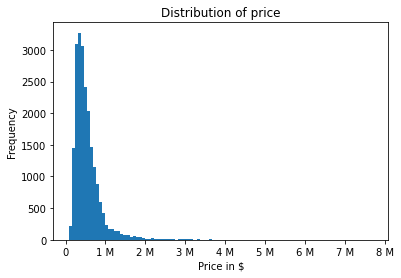

In [492]:

axw = plt.subplot()
axw.xaxis.set_major_formatter(ticker.EngFormatter())
plt.gca().set(title='Distribution of price', xlabel= 'Price in $', ylabel='Frequency');
plt.hist(df_king_county.price, bins=100);

### The prices are right skewed. Since the Stakeholder is not looking for houses in the highest price segments, these can be removed from the data. Then the prices are more normal distributed.

In [493]:
df_king_county_cut = df_king_county.drop(df_king_county[df_king_county.price > 2500000].index)
df_king_county.shape

(21597, 21)

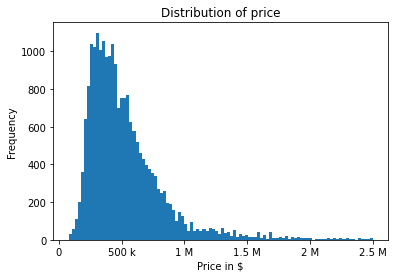

In [494]:
axw = plt.subplot()
axw.xaxis.set_major_formatter(ticker.EngFormatter())
plt.gca().set(title='Distribution of price', xlabel= 'Price in $', ylabel='Frequency');
plt.hist(df_king_county_cut.price, bins=100);

### Distribution of price for every grade (3 to 13)

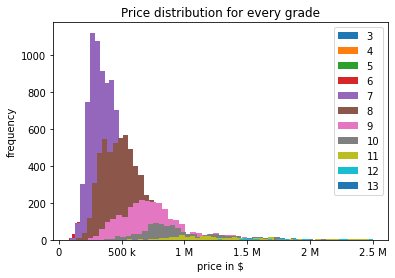

In [495]:
axw = plt.subplot()
axw.xaxis.set_major_formatter(ticker.EngFormatter())
grades = range(3,14)
for g in grades:
    plt.hist(df_king_county_cut.price.loc[df_king_county_cut.grade == g], bins=50)
plt.title('Price distribution for every grade')    
plt.xlabel('price in $')
plt.ylabel('frequency')
plt.legend(grades);    


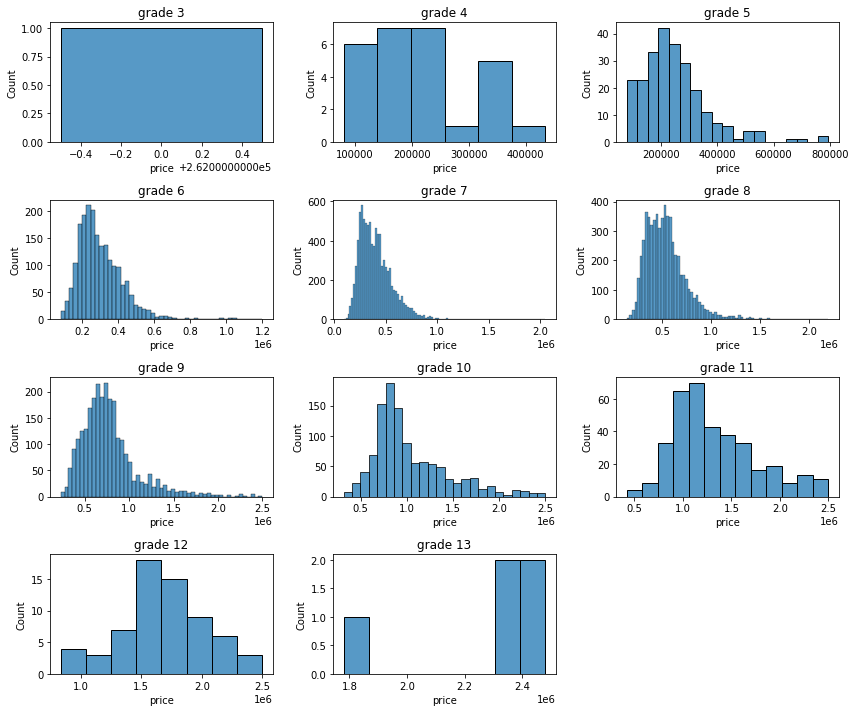

In [496]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
for i in range(1,12):
    plt.subplot(4,3,i) 
    sns.histplot(data=df_king_county_cut, x = df_king_county_cut.price.loc[df_king_county_cut.grade == i+2])
    plt.title('grade {}'.format(i+2))
        
plt.tight_layout()

# Hypothesis 1: Seasons might influence the price, summer could be the best time to buy

### Comparison of average prices over months

Text(0.5, 1.0, 'Average prices per month')

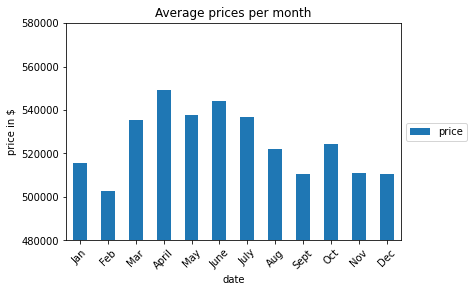

In [497]:
# add column price per sqft
df_king_county_cut.eval('sqft_price = price / sqft_living', inplace=True)  
df_king_county_cut.sqft_price = df_king_county_cut.sqft_price.apply(lambda x: round(x, 2)) 


#what month had the lowest average price?
#change date to months only
df_months = df_king_county_cut.copy()
df_months.date = df_king_county_cut.date.dt.month

df_month_mean = df_months.groupby('date').mean().price
labels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

df = pd.DataFrame({'date': labels,'price': df_month_mean.values})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'price', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(480000, 580000)
plt.title('Average prices per month')

### Comparison of average prices in May 2014 and May 2015

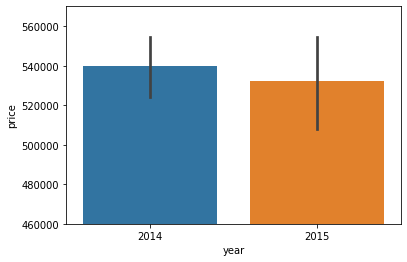

In [498]:
df_king_county_cut['month'] = df_king_county_cut['date'].dt.month
df_king_county_cut['year'] = df_king_county_cut['date'].dt.year
xplot = df_king_county_cut.query('month==5').year
plt.ylim(460000, 570000)
sns.barplot(x=xplot, y='price', data = df_king_county_cut);

### Comparison of average sqft prices over months

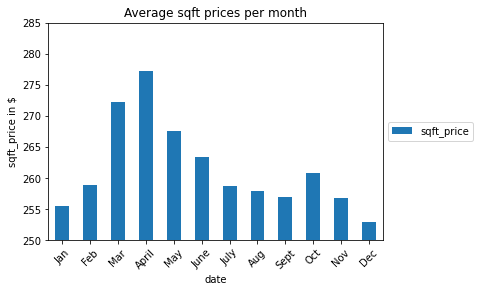

In [499]:
df_month_mean = df_months.groupby('date').mean().sqft_price
df2 = pd.DataFrame({'date': labels,'sqft_price': df_month_mean.values})
ax2 = plt.subplot()
fig2 = df2.plot(kind = 'bar', x = 'date', y = 'sqft_price',ax = ax2)
plt.xticks(rotation =45)
plt.ylabel('sqft_price in $')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(250, 285)
plt.title('Average sqft prices per month');


### How many houses are sold every month?

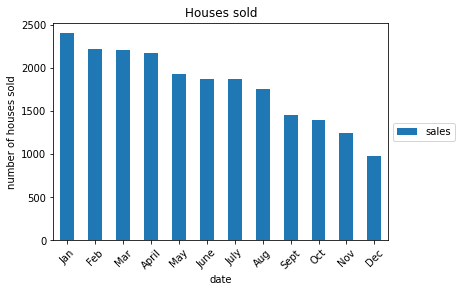

In [500]:
df = pd.DataFrame({'date': labels,'sales': df_months.date.value_counts()})
ax = plt.subplot()
fig = df.plot(kind = 'bar', x = 'date', y = 'sales', ax = ax)
plt.xticks(rotation =45)
plt.ylabel('number of houses sold')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Houses sold')
ax;


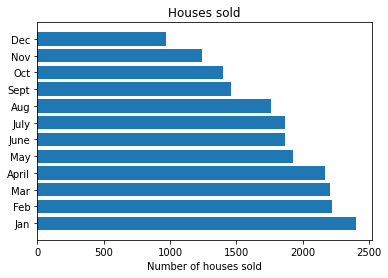

In [501]:
plt.barh(y=df.date, width=df.sales)
plt.title('Houses sold')
plt.xlabel('Number of houses sold');

# Hypothesis 2: High grade houses are sold at higher price 

### Grade has values from 3 to 13.

In [502]:
d=df_king_county_cut[['grade', 'price']]
d.sort_values('grade')  
df_king_county_cut.grade.min()
df_king_county_cut.grade.max()


13


### There are many outliers. My stakeholder is looking for houses in poor neighborhood, which she wants to sell with little profit only. The expensive house are not in her focus, so I will delete for every grade the expensive houses.

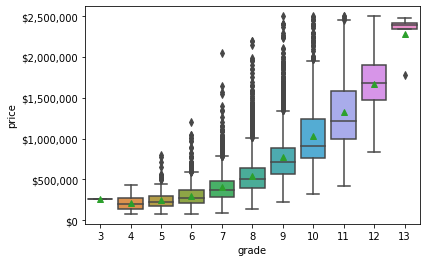

In [503]:
# grade vs price
axw = plt.subplot()
axw.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.ylabel('Price')
sns.boxplot(x='grade', y = 'price', data=df_king_county_cut, showmeans = True);

In [504]:
# remove outliers for grade 5 to 12
# remove outliers that more than one standard deviation away from the mean
for i in range(5, 13): 
   df_outliers = df_king_county_cut.query('grade=={}'.format(i))
   mean = df_outliers.price.mean()
   standard_dev = np.std(df_outliers.price)
   df_king_county_cut = df_king_county_cut.drop(df_king_county_cut[(df_king_county_cut.price > standard_dev+mean) & (df_king_county_cut.grade == i)].index)

### Without the outliers the grade - price relation looks more linear.

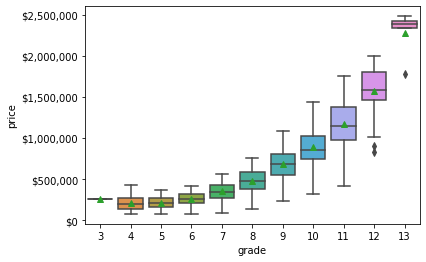

In [505]:
# grade vs price
axw = plt.subplot()
axw.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.ylabel('Price')
sns.boxplot(x='grade', y = 'price', data=df_king_county_cut, showmeans = True);

### Grade vs price as Linechart

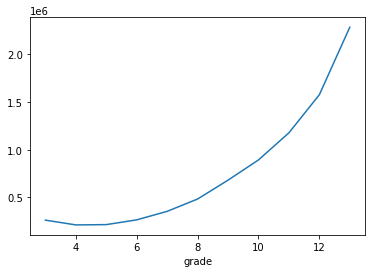

In [506]:
df_king_county_cut.groupby('grade').price.mean().plot();

### Fit OLS model



In [507]:
#create OLS model
X = df_king_county_cut.grade
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.136e+04
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:32:13   Log-Likelihood:            -2.4618e+05
No. Observations:               18519   AIC:                         4.924e+05
Df Residuals:                   18517   BIC:                         4.924e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.771e+05   7099.020   -109.463      0.000   -7.91e+05   -7.63e+05
grade       1.626e+05    918.236    177.090      0.000    1.61e+05    1.64e+05
==============================================================================
Omnibus:                     1814.987   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4758.009
Skew:                           0.563   Prob(JB):                         0.00
Kurtosis:                       5.213   Cond. No.                         52.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting the result of the linear regression, i.e. regression line.

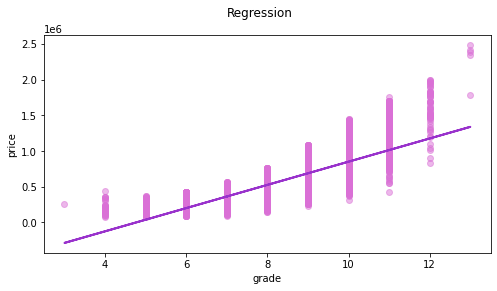

In [508]:

intercept, slope = results.params

fig, ax = plt.subplots(figsize=(8, 4))
x = df_king_county_cut.grade
# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Regression')
# plotting regression line
ax.plot(x, x*slope +intercept, '-', color='darkorchid', linewidth=2);
ax.set_ylabel("price");
ax.set_xlabel("grade");

### Every extra point in grade costs about 170K $

In [509]:
slope

162610.31835048823

### Plotting the residuals

eval_env: 1


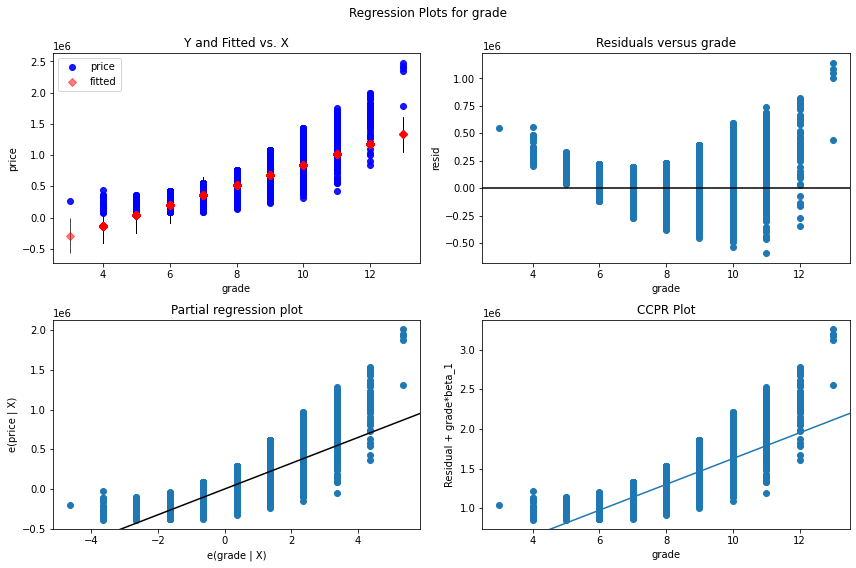

In [510]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'grade', fig=fig);



### Conclusions: <br>
- The R-squared is 0.63. There is some improvement needed <br>
- The p-value for `grade` is 0, so since the p-value is smaller than 0.05, `grade` cannot be rejected as a significant predictor<br>
- There is a linear relationship between `grade` and `price`. The feataure `grade` explains 63% of the variance in `price`.
- The residuals are not randomly distributed. One feature is not enough to make a good prediction on the price. 


### Looking for more relevant features:


The heatmap  and the pairchart below show that there a five features, besides ```grade```,  that have a high correlation with `price`: 
* `bathrooms`
* `sqft_living`
* `grade`
* `sqft_above`
* `sqft_living15`
* `sqft_price`

`sqft_price` can not be used for regression, because of the collinearity with `price`. <br>
`sqft_above` is highly correlated with `sqft_living`, the correlation is above 0.8, so I will also drop `sqft_above` from the features. 

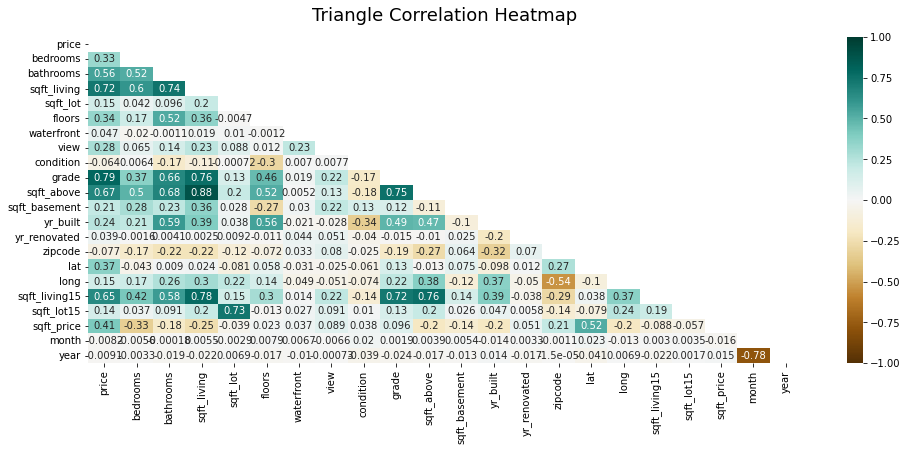

In [511]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
df_heatmap = df_king_county_cut.drop('id',1)
mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_heatmap.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

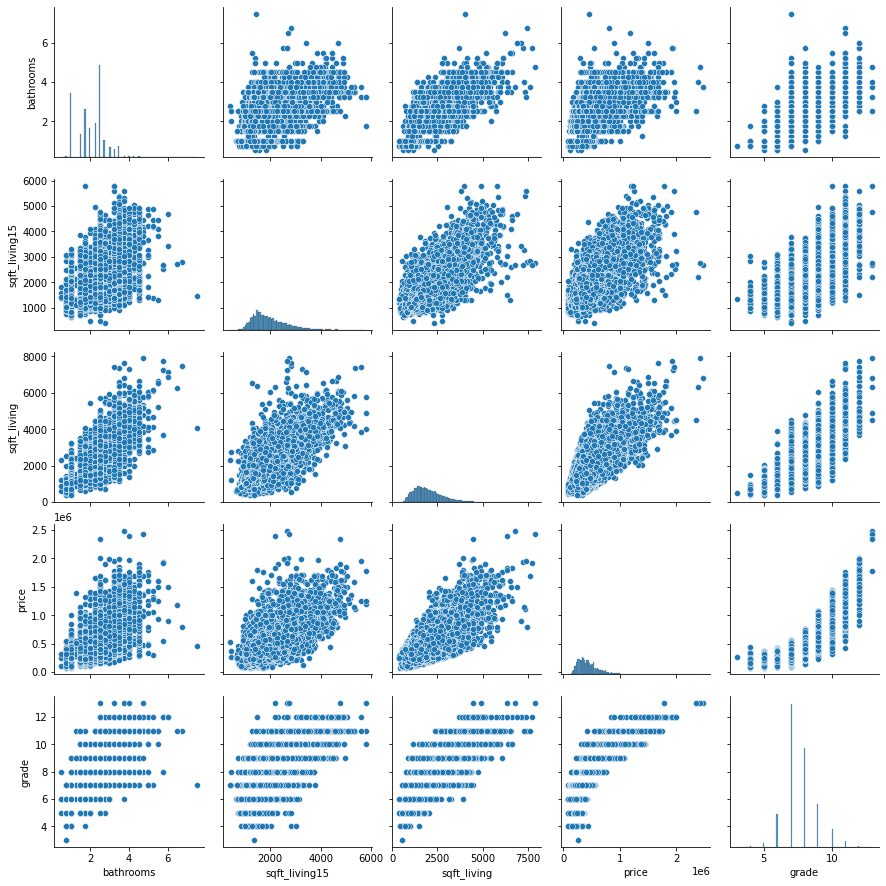

In [512]:
x_columns = ['bathrooms','sqft_living15', 'sqft_living', 'price', 'grade']
sns.pairplot(df_king_county_cut[x_columns]);

### Creating OLS model with  4 features. The result is a little better than the regression with only one feature, grade. 
### The R-squared is 0.67 vs 0.63.

In [513]:
#create OLS model
X = df_king_county_cut[['bathrooms', 'sqft_living15', 'grade', 'sqft_living']]
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     9203.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:32:28   Log-Likelihood:            -2.4522e+05
No. Observations:               18519   AIC:                         4.904e+05
Df Residuals:                   18514   BIC:                         4.905e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.901e+05   7990.465    -73.852      0.000   -6.06e+05   -5.74e+05
bathrooms     -2.187e+04   2081.471    -10.509      0.000    -2.6e+04   -1.78e+04
sqft_living15    14.1783      2.519      5.628      0.000       9.240      19.116
grade          1.186e+05   1462.167     81.099      0.000    1.16e+05    1.21e+05
sqft_living      83.3129      2.372     35.127      0.000      78.664      87.962
==============================================================================
Omnibus:                     1663.483   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4430.273
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       5.164   Cond. No.                     2.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plot Residuals against bathroom

eval_env: 1


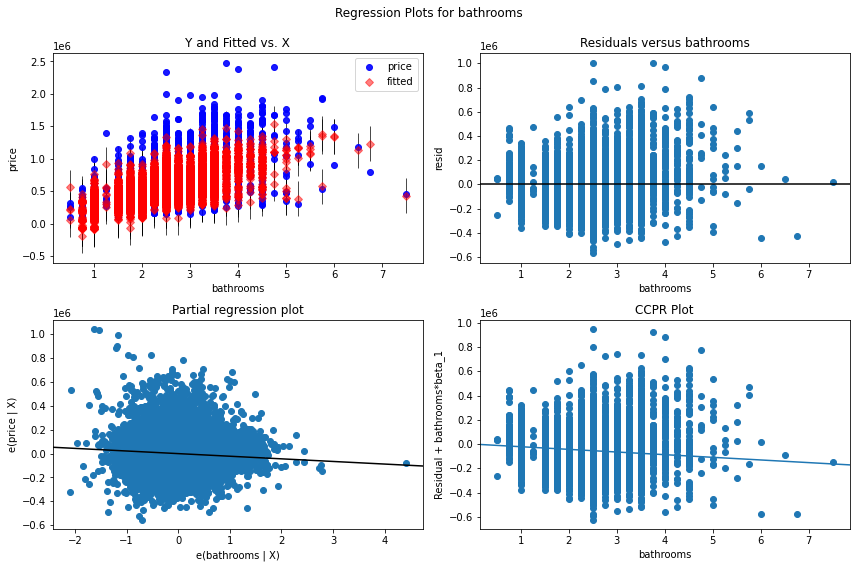

In [514]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'bathrooms', fig=fig);

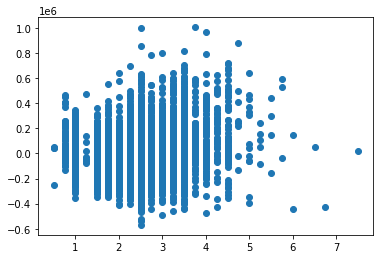

In [515]:
plt.scatter(results.model.exog[:,1], results.resid);

### Plot - Residuals against all features used in the regression model.

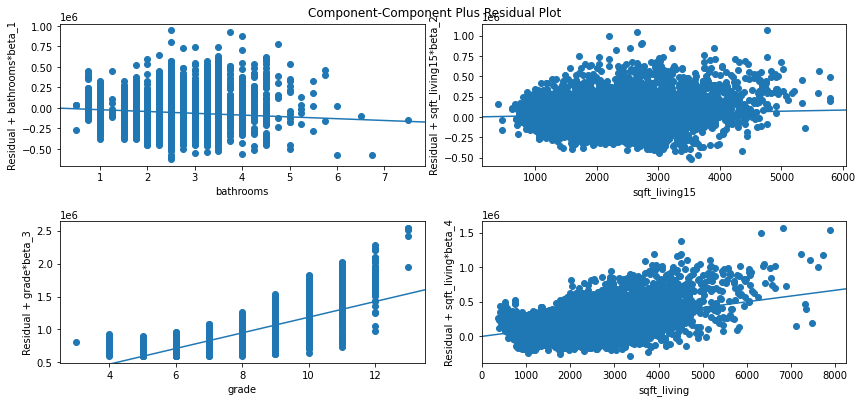

In [516]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(results, fig=fig)

### What are the average houseprices depending on number of bathroom? 

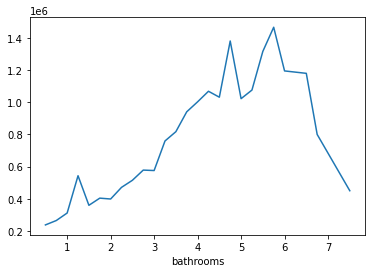

In [517]:
df_king_county_cut.groupby('bathrooms').price.mean().plot();

### In average the more bathrooms the higher the house price. Only houses with number of bathrooms between 7 and 8 have a downpeak in price. In the histogram below you can see that there is only one house that has 7.5 bathrooms.

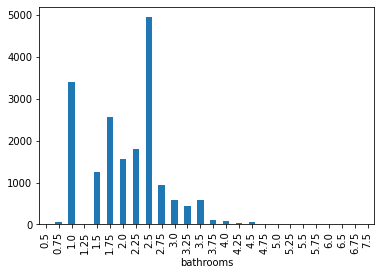

In [518]:
df_bathr = df_king_county_cut.groupby('bathrooms').id.count()
df_bathr.plot(kind='bar');

In [519]:
b = df_king_county_cut.query('bathrooms > 4.5')

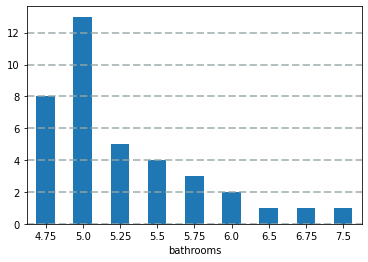

In [520]:
df_bathr2 = df_king_county_cut.query('bathrooms > 4.5').groupby('bathrooms').id.count().plot(kind='bar')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation = 0);

In [521]:
df_king_county_cut.bathrooms.unique()

array([1.  , 2.25, 2.  , 4.5 , 1.5 , 2.5 , 1.75, 3.  , 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 4.25, 5.  , 1.25, 3.75, 0.5 , 5.5 , 5.25, 6.75,
       5.75, 7.5 , 6.5 , 6.  ])

In [522]:
df_king_county_cut[df_king_county_cut['bathrooms']>=6].sort_values(by = ['bathrooms']).head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_price,month,year
21034,2424059170,2015-02-19,900000.0,5,6.00,7120,40806,2.0,0.0,4.0,...,2007,0.0,98006,47.5451,-122.114,3440,36859,126.40,2,2015
21328,8835770170,2014-08-22,1490000.0,5,6.00,6880,279968,2.0,0.0,3.0,...,2007,0.0,98045,47.4624,-121.779,4690,256803,216.57,8,2014
20562,424069279,2015-03-28,1180000.0,6,6.50,6260,10955,2.0,0.0,0.0,...,2007,0.0,98075,47.5947,-122.039,2710,12550,188.50,3,2015
4020,9175600025,2014-10-07,800000.0,7,6.75,7480,41664,2.0,0.0,2.0,...,1953,0.0,98166,47.4643,-122.368,2810,33190,106.95,10,2014
8537,424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0.0,0.0,...,1996,0.0,98144,47.5923,-122.301,1448,3866,111.11,8,2014


In [523]:
df_king_county_cut[df_king_county_cut['bathrooms']>6][['grade','bathrooms']]

,grade,bathrooms
4020,11,6.75
8537,7,7.50
20562,11,6.50


### The house with 7.5 bathrooms has only grade 7 which is bad compared to grade of the other houses with more than 6 bathrooms that have grads 11 and 12. This house does also have a lower sqft price, so probably it is not in too good condition, and also it is small, since sqft_living is also smaller compared to the other houses with that many bathrooms.

Sqft_living and sqft_living15 also seem to have a linear relationship to the price. I won't analyse that in detail here now.

# Hypothesis 3: Prices rely on the area, i.e. Zipcode

### Converting zipcodes to citynames. There are 69 zipcodes in the cleaned dataframe.

In [524]:
df_king_county_cut.groupby('zipcode').count()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_price,month,year
zipcode,,,,,,,,,,,,,,,,,,,,,
98001,361,361,361,361,361,361,361,361,361,361,...,361,361,361,361,361,361,361,361,361,361
98002,199,199,199,199,199,199,199,199,199,199,...,199,199,199,199,199,199,199,199,199,199
98003,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
98004,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
98005,121,121,121,121,121,121,121,121,121,121,...,121,121,121,121,121,121,121,121,121,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,214,214,214,214,214,214,214,214,214,214,...,214,214,214,214,214,214,214,214,214,214
98178,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
98188,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136


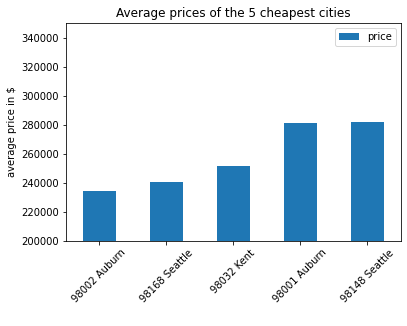

In [525]:
b = df_king_county_cut.groupby('zipcode').price.mean().sort_values().head(5)
  
dfb = pd.DataFrame({'zipcode': [str(z)+' '+get_location(z) for z in b.index], 'price': b.values})
axb = plt.subplot()
figb = dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=45)
plt.ylabel('average price in $')
plt.title('Average prices of the 5 cheapest cities')
plt.ylim(200000,350000)
plt.xlabel(' ');


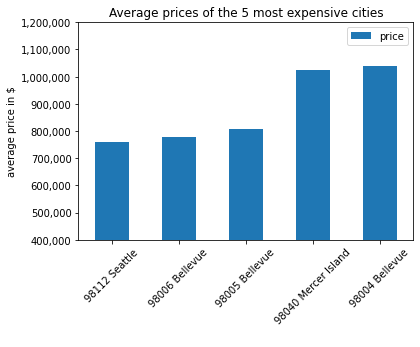

In [526]:
b = df_king_county_cut.groupby('zipcode').price.mean().sort_values().tail()
dfb = pd.DataFrame({'zipcode': [str(z)+' '+get_location(z) for z in b.index],  'price': b.values})
axb = plt.subplot()
axb.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
dfb.plot(kind = 'bar', x = 'zipcode', y = 'price', ax = axb)
plt.xticks(rotation=45)
plt.ylabel('average price in $')
plt.title('Average prices of the 5 most expensive cities')
get_location(98001)
plt.xlabel(' ')
plt.ylim(400000,1200000);

### `zipcode` could be an important feature. To use this feature for regression I will create dummy variables, since `zipcode` is a categorical feature.   

In [527]:
# create dummy variables for 'zipcode'
zip_dummies = pd.get_dummies(df_king_county_cut.zipcode, drop_first=True)
df_king_county_cut = pd.concat([zip_dummies,df_king_county_cut], axis = 1)

In [528]:
df_king_county_cut.head()

,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_price,month,year
0,0,0,0,0,0,0,0,0,0,0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,188.05,10,2014
1,0,0,0,0,0,0,0,0,0,0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,209.34,12,2014
2,0,0,0,0,0,0,0,0,0,0,...,1933,0.0,98028,47.7379,-122.233,2720,8062,233.77,2,2015
4,0,0,0,0,0,0,0,0,0,0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,303.57,2,2015
5,0,0,0,0,0,0,0,0,0,0,...,2001,0.0,98053,47.6561,-122.005,4760,101930,226.94,5,2014


In [529]:
#create OLS model
X = pd.DataFrame(zip_dummies)
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     208.3
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:32:36   Log-Likelihood:            -2.5008e+05
No. Observations:               18519   AIC:                         5.003e+05
Df Residuals:                   18450   BIC:                         5.008e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.812e+05   9342.364     30.099      0.000    2.63e+05       3e+05
98002      -4.691e+04   1.57e+04     -2.993      0.003   -7.76e+04   -1.62e+04
98003       1.292e+04   1.41e+04      0.914      0.361   -1.48e+04    4.06e+04
98004       7.577e+05   2.55e+04     29.720      0.000    7.08e+05    8.08e+05
98005       5.257e+05   1.86e+04     28.192      0.000    4.89e+05    5.62e+05
98006       4.961e+05   1.28e+04     38.856      0.000    4.71e+05    5.21e+05
98007       3.342e+05   1.82e+04     18.405      0.000    2.99e+05     3.7e+05
98008       2.653e+05   1.51e+04     17.548      0.000    2.36e+05    2.95e+05
98010       1.301e+05   2.07e+04      6.275      0.000    8.95e+04    1.71e+05
98011       2.088e+05   1.58e+04     13.215      0.000    1.78e+05     2.4e+05
98014       1.657e+05   1.89e+04      8.747      0.000    1.29e+05    2.03e+05
98019       1.389e+05    1.6e+04      8.671      0.000    1.08e+05     1.7e+05
98022       3.321e+04    1.5e+04      2.220      0.026    3892.739    6.25e+04
98023       3814.4936   1.23e+04      0.311      0.756   -2.02e+04    2.79e+04
98024       2.612e+05   2.29e+04     11.403      0.000    2.16e+05    3.06e+05
98027       3.129e+05    1.3e+04     24.151      0.000    2.88e+05    3.38e+05
98028       1.699e+05   1.42e+04     11.931      0.000    1.42e+05    1.98e+05
98029       3.189e+05   1.37e+04     23.302      0.000    2.92e+05    3.46e+05
98030       1.499e+04   1.45e+04      1.034      0.301   -1.34e+04    4.34e+04
98031       1.746e+04   1.43e+04      1.225      0.221   -1.05e+04    4.54e+04
98032       -2.99e+04   1.84e+04     -1.623      0.105    -6.6e+04    6208.795
98033       4.299e+05   1.41e+04     30.382      0.000    4.02e+05    4.58e+05
98034       1.988e+05   1.22e+04     16.344      0.000    1.75e+05    2.23e+05
98038       8.406e+04   1.19e+04      7.076      0.000    6.08e+04    1.07e+05
98040       7.415e+05   1.86e+04     39.769      0.000    7.05e+05    7.78e+05
98042       2.803e+04   1.21e+04      2.325      0.020    4399.355    5.17e+04
98045       1.573e+05   1.52e+04     10.317      0.000    1.27e+05    1.87e+05
98052       3.515e+05   1.21e+04     28.976      0.000    3.28e+05    3.75e+05
98053       3.855e+05   1.32e+04     29.100      0.000     3.6e+05    4.12e+05
98055       2.129e+04   1.43e+04      1.484      0.138   -6823.226    4.94e+04
98056        1.24e+05   1.29e+04      9.613      0.000    9.87e+04    1.49e+05
98058       6.797e+04   1.25e+04      5.419      0.000    4.34e+04    9.26e+04
98059       2.125e+05   1.25e+04     17.066      0.000    1.88e+05    2.37e+05
98065       2.484e+05   1.38e+04     18.028      0.000    2.21e+05    2.75e+05
98070       1.798e+05   1.99e+04      9.031      0.000    1.41e+05    2.19e+05
98072       2.801e+05   1.44e+04     19.424      0.000    2.52e+05    3.08e+05
98

``` zipcode``` explains   ~42% of ```price```.  So I will use it for another multilinear regression. 

In [530]:
# Merge the dummies with the 4 features from the previous regression
df_4 = df_king_county_cut.loc[:,['bathrooms', 'sqft_living15', 'grade', 'sqft_living']]
df_ols = pd.concat([zip_dummies, df_4], axis=1)

In [531]:
#create OLS model
X = df_ols
X = sm.add_constant(X)
y = df_king_county_cut.price
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1332.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:32:37   Log-Likelihood:            -2.3846e+05
No. Observations:               18519   AIC:                         4.771e+05
Df Residuals:                   18446   BIC:                         4.776e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -4.74e+05   7776.696    -60.952      0.000   -4.89e+05   -4.59e+05
98002          3.455e+04   8386.905      4.119      0.000    1.81e+04     5.1e+04
98003         -8208.0919   7553.388     -1.087      0.277    -2.3e+04    6597.248
98004          5.054e+05   1.37e+04     36.882      0.000    4.79e+05    5.32e+05
98005          3.122e+05      1e+04     31.103      0.000    2.93e+05    3.32e+05
98006          2.707e+05   6934.007     39.045      0.000    2.57e+05    2.84e+05
98007          2.474e+05   9715.510     25.462      0.000    2.28e+05    2.66e+05
98008          2.293e+05   8081.238     28.374      0.000    2.13e+05    2.45e+05
98010          8.215e+04   1.11e+04      7.417      0.000    6.04e+04    1.04e+05
98011           1.27e+05   8457.091     15.015      0.000     1.1e+05    1.44e+05
98014          1.257e+05   1.01e+04     12.416      0.000    1.06e+05    1.46e+05
98019          8.946e+04   8566.992     10.442      0.000    7.27e+04    1.06e+05
98022           4.76e+04   7988.619      5.959      0.000    3.19e+04    6.33e+04
98023         -2.855e+04   6558.133     -4.353      0.000   -4.14e+04   -1.57e+04
98024          1.927e+05   1.22e+04     15.737      0.000    1.69e+05    2.17e+05
98027          1.753e+05   6958.723     25.198      0.000    1.62e+05    1.89e+05
98028          1.215e+05   7611.463     15.969      0.000    1.07e+05    1.36e+05
98029          1.993e+05   7367.651     27.046      0.000    1.85e+05    2.14e+05
98030          -788.1936   7749.210     -0.102      0.919    -1.6e+04    1.44e+04
98031          7889.8893   7615.388      1.036      0.300   -7036.976    2.28e+04
98032           491.2944   9845.960      0.050      0.960   -1.88e+04    1.98e+04
98033          3.062e+05   7592.773     40.331      0.000    2.91e+05    3.21e+05
98034          1.844e+05   6499.843     28.375      0.000    1.72e+05    1.97e+05
98038          3.096e+04   6364.003      4.865      0.000    1.85e+04    4.34e+04
98040          4.405e+05   1.01e+04     43.613      0.000    4.21e+05     4.6e+05
98042          7351.6745   6441.123      1.141      0.254   -5273.522       2e+04
98045          1.137e+05   8147.925     13.951      0.000    9.77e+04     1.3e+05
98052          2.241e+05   6526.390     34.338      0.000    2.11e+05    2.37e+05
98053          2.219e+05   7129.636     31.120      0.000    2.08e+05    2.36e+05
98055          4.632e+04   7661.933      6.045      0.000    3.13e+04    6.13e+04
98056          1.081e+05   6891.742     15.690      0.000    9.46e+04    1.22e+05
98058          3.084e+04   6702.130      4.601      0.000    1.77e+04     4.4e+04
98059          1.019e+05   6683.608     15.251      0.000    8.88e+04    1.15e+05
98065          1.183e+05   7422.693     15.932      0.000    1.04e+05    1.33e+05
98070          1.725e+05   1.06e+04     16.221   

### With the additional feature `zipcode` the r-squared is 0.82. This is a big improvement.

### Prices rely also on the shoreline location, does the house have a waterfront or not.

In [532]:
# average price for a house with waterfront : ~$1.7 M
df_king_county.query('waterfront==1').price.mean()

1717214.7260273972

In [533]:
# average price for a house without waterfront : ~$535 K
df_king_county.query('waterfront==0').price.mean()


532286.2219943126

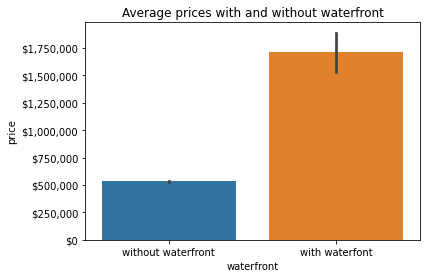

In [534]:
p = sns.barplot(x='waterfront', y='price', data=df_king_county)
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
p.set_xticklabels(['without waterfront', 'with waterfont'])
p.set_title('Average prices with and without waterfront');

### Comparing prices in different zipcodes regarding waterfront.

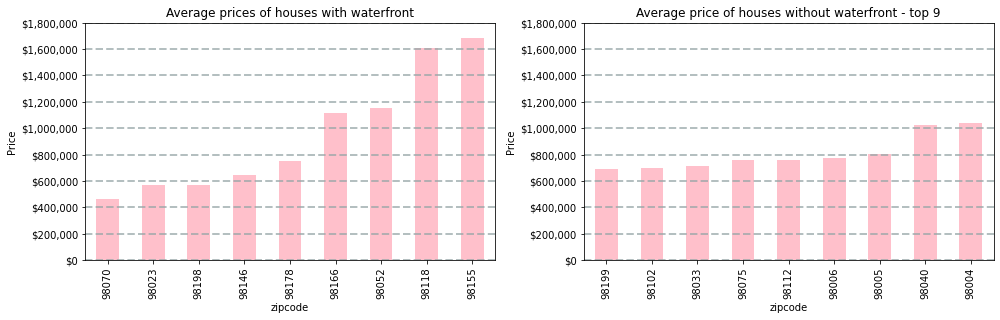

In [535]:
plt.figure(figsize = (14,8))
axw = plt.subplot(2,2,1)
axw.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.ylabel('Price')
df_king_county_cut.query('waterfront==1').groupby('zipcode').price.mean().sort_values().tail(9).plot(kind='bar',title="Average prices of houses with waterfront", color='pink')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
#plt.rcParams["figure.figsize"]=(14,8)
plt.ylim(0,1800000)
axwo = plt.subplot(2,2,2)
axwo.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.ylabel('Price')
df_king_county_cut.query('waterfront==0').groupby('zipcode').price.mean().sort_values().tail(9).plot(kind='bar', title="Average price of houses without waterfront - top 9", color='pink')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.ylim(0,1800000)
plt.tight_layout()


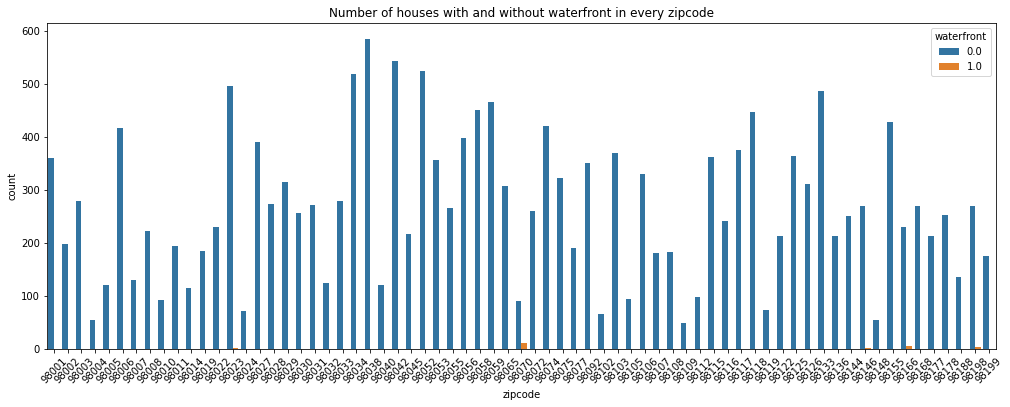

In [536]:
plt.figure(figsize = (17,6))
ax = sns.countplot(x="zipcode", hue="waterfront", data=df_king_county_cut)
plt.title('Number of houses with and without waterfront in every zipcode')
plt.xticks(rotation = 45);

Plotting houses with waterfront on the map:

In [537]:
waterfront = df_king_county[(df_king_county['waterfront'] == 1)]
waterfront_map = folium.Map(location=[47.6561, -122.005], zoom_start=10, tiles='openstreetmap')
                        
for i in waterfront.index:
    lat = waterfront.lat[i]
    long = waterfront.long[i]
    price = round(waterfront.price[i])
    popup_text = "Price: {}$".format(price)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker([lat, long], popup=popup).add_to(waterfront_map)

    
waterfront_map

In [538]:
# only 146 houses have a waterfront, 21451 don't have a waterfront.
houses_no_wfr = df_king_county_cut.query('waterfront==0').count()
houses_wfr = df_king_county_cut.query('waterfront==1').count()

### In which Zipcodes / Cities are the houses with waterfront?

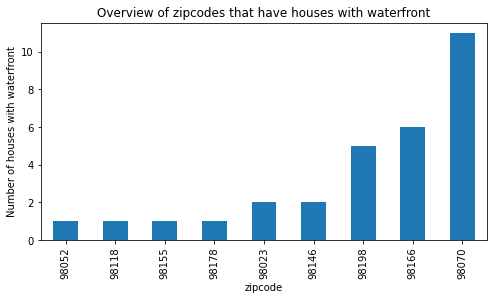

In [539]:
waterfront=df_king_county_cut[df_king_county['waterfront']==1]
plt.figure(figsize = (8,4))
waterfront.groupby('zipcode').waterfront.count().sort_values().plot(kind='bar')
plt.title('Overview of zipcodes that have houses with waterfront')
plt.ylabel('Number of houses with waterfront');

### Are the houses with waterfront all in the expensive cities? No they are not, yet they are 3 times more expensive in average.

In [540]:
# in which zipcodes are houses with waterfront?
zip = df_king_county_cut.query('waterfront==1')
zip_list = np.array(zip.groupby('zipcode').count().index)
zip_list

array([98023, 98052, 98070, 98118, 98146, 98155, 98166, 98178, 98198])

In [541]:
# in which zipcodes are the in average most expensive houses?
df_exp = df_king_county_cut.groupby('zipcode').price.mean().sort_values().tail(10)
list_exp = df_exp.index
list_exp

Int64Index([98077, 98199, 98102, 98033, 98075, 98112, 98006, 98005, 98040,
            98004],
           dtype='int64', name='zipcode')

In [542]:
# the houses with waterfront are not in any of the 10 most expensive cities
set(zip_list).issubset(set(list_exp))

False

In [543]:
set(zip_list).isdisjoint(set(list_exp))    

True

# Conclusions and recommendations for my stakeholder
1. End of the year the house prices and the sqft_prices are lowest in average, and also fewer houses are sold. So that time of the year could be good to find a cheap house. <br>
2. Buy houses with lower grade and fewer bathrooms, as well as smaller size in terms of sqft_living, sqft_living15, and sqft_above.<br>
3. Location wise 98002 Auburn, 98168 Seattle, and 98032 Kent are good cities to find houses in poor neighborhood, and also in general houses without a waterfront.
    No need to look for a house in 98004 Bellevue, and 
   98040 Mercer Island, since this are the most expensive cities.


-----------------------------------------
Appendix

Plotting houses in Auburn, Seattle and Kent

In [544]:
Auburn_Seattle_Kent = df_king_county[(df_king_county['zipcode'] == 98002) | (df_king_county['zipcode'] == 98168) | (df_king_county['zipcode'] == 98032)]  
map = folium.Map(location=[47.6561, -122.005], zoom_start=10, tiles='openstreetmap')
                        
for i in Auburn_Seattle_Kent.index:
    lat = Auburn_Seattle_Kent.lat[i]
    long = Auburn_Seattle_Kent.long[i]
    price = round(Auburn_Seattle_Kent.price[i])
    popup_text = "Price: {}$".format(price)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker([lat, long], popup=popup).add_to(map)

map

Distribution of price

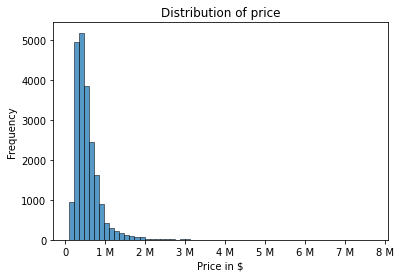

In [545]:
axw = plt.subplot()
axw.xaxis.set_major_formatter(ticker.EngFormatter())
plt.gca().set(title='Distribution of price', xlabel= 'Price in $', ylabel='Frequency');
sns.histplot(data=df_king_county, x=df_king_county.price, bins = 60);